In [ ]:
# Import required libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from pathlib import Path
from tqdm import tqdm
import xml.etree.ElementTree as ET  # For parsing XML annotation files

# Set random seed for reproducibility
random.seed(42)

# License Plate Dataset Processing

This notebook loads and processes the license plate detection dataset:
- Dataset: Located in `c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\DataV3\images`
- Contains images (.jpeg) with license plate annotations
- Annotations are in XML format in the same directory as the images

We'll:
1. Load the dataset from the local folder
2. Parse the XML annotation files
3. Visualize sample images with bounding boxes

## 1. Load the Dataset

First, we'll set up the paths to the local dataset in DataV3 folder.
It contains 207 images

In [ ]:
# Set up paths to the local dataset
base_dir = os.path.abspath(r"c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\DataV3")
data_dir = os.path.join(base_dir, "images")  # Directory containing both images and XML files

# Verify the dataset exists
if os.path.exists(base_dir) and os.path.exists(data_dir):
    print(f"✓ Dataset found at {base_dir}")
    print(f"✓ Data directory found at {data_dir}")
    
    # Count images
    image_count = len([f for f in os.listdir(data_dir) if f.lower().endswith('.jpeg')])
    print(f"✓ Found {image_count} images in the data directory")
    
    # Count XML files
    xml_count = len([f for f in os.listdir(data_dir) if f.lower().endswith('.xml')])
    print(f"✓ Found {xml_count} XML annotation files")
    
    # Set path for further processing
    path = data_dir
else:
    missing = []
    if not os.path.exists(base_dir):
        missing.append(f"Base directory: {base_dir}")
    if not os.path.exists(data_dir):
        missing.append(f"Data directory: {data_dir}")
    
    print("Error: Could not find the dataset. The following components are missing:")
    for item in missing:
        print(f"- {item}")

Error: Could not find the dataset. The following components are missing:
- Training directory: c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\DataV3\images\images
- Annotation directory: c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\DataV3\images\annotations


## 2. Explore the Dataset Structure

Let's explore the dataset structure to understand how XML annotations and images are organized.

In [ ]:
# Check the dataset structure
def explore_dataset_structure(dataset_path):
    print(f"Dataset path: {dataset_path}")
    
    # List all files in the dataset
    all_files = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            all_files.append(os.path.join(root, file))
    
    # Display statistics
    print(f"Total files: {len(all_files)}")
    
    # Group by extension
    extensions = {}
    for file in all_files:
        ext = os.path.splitext(file)[1].lower()
        if ext not in extensions:
            extensions[ext] = 0
        extensions[ext] += 1
    
    print("\nFile types:")
    for ext, count in extensions.items():
        print(f"  {ext}: {count} files")
    
    # Find XML files (annotations)
    xml_files = [f for f in all_files if f.endswith('.xml')]
    print(f"\nXML files (annotations): {len(xml_files)}")
    if xml_files:
        print(f"  Sample XML file: {os.path.basename(xml_files[0])}")
    
    # Find images
    image_files = [f for f in all_files if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
    print(f"\nImage files: {len(image_files)}")
    if image_files:
        print(f"  Sample image file: {os.path.basename(image_files[0])}")
    
    # Match images with annotations
    image_bases = [os.path.splitext(os.path.basename(f))[0] for f in image_files]
    xml_bases = [os.path.splitext(os.path.basename(f))[0] for f in xml_files]
    
    matches = set(image_bases).intersection(set(xml_bases))
    print(f"\nMatching image-annotation pairs: {len(matches)}")
    
    return all_files, xml_files, image_files

# Run the exploration
all_files, xml_files, image_files = explore_dataset_structure(path)

Dataset path: c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\DataV3
Total files: 418

File types:
  .jpeg: 211 files
  .xml: 207 files

XML files (annotations): 207
  Sample XML file: N1.xml

Directories containing images:
  c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\DataV3\images: 211 images


## 3. Parse the XML Annotations

The annotations are in XML format with elements for coordinates, filename, dimensions, and object information. Let's create a function to parse these XML files.

In [ ]:
# Function to parse XML annotation file
def parse_xml_annotation(xml_file):
    try:
        # Parse XML file
        tree = ET.parse(xml_file)
        root = tree.getroot()
        
        # Get filename
        filename = root.find('filename').text
        
        # Get path if available
        path_elem = root.find('path')
        path = path_elem.text if path_elem is not None else ''
        
        # Get size information
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        depth = int(size.find('depth').text) if size.find('depth') is not None else 3
        
        # Get object information
        objects = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            
            # Get bounding box
            bbox = obj.find('bndbox')
            xmin = int(float(bbox.find('xmin').text))
            ymin = int(float(bbox.find('ymin').text))
            xmax = int(float(bbox.find('xmax').text))
            ymax = int(float(bbox.find('ymax').text))
            
            # Get other attributes if available
            pose_elem = obj.find('pose')
            pose = pose_elem.text if pose_elem is not None else 'Unspecified'
            
            truncated_elem = obj.find('truncated')
            truncated = int(truncated_elem.text) if truncated_elem is not None else 0
            
            difficult_elem = obj.find('difficult')
            difficult = int(difficult_elem.text) if difficult_elem is not None else 0
            
            objects.append({
                'name': name,
                'pose': pose,
                'truncated': truncated,
                'difficult': difficult,
                'xmin': xmin,
                'ymin': ymin,
                'xmax': xmax,
                'ymax': ymax
            })
        
        return {
            'filename': filename,
            'path': path,
            'width': width,
            'height': height,
            'depth': depth,
            'objects': objects
        }
    except Exception as e:
        print(f"Error parsing XML file {xml_file}: {e}")
        return None

# Load all XML annotations
def load_all_annotations(data_dir):
    print(f"Loading XML annotations from {data_dir}...")
    
    annotations = []
    xml_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.lower().endswith('.xml')]
    
    print(f"Found {len(xml_files)} XML files")
    
    for xml_file in tqdm(xml_files, desc="Parsing XML files"):
        annotation = parse_xml_annotation(xml_file)
        if annotation:
            for obj in annotation['objects']:
                annotations.append({
                    'file': os.path.splitext(os.path.basename(xml_file))[0],  # Base name without extension
                    'width': annotation['width'],
                    'height': annotation['height'],
                    'class': obj['name'],
                    'pose': obj['pose'],
                    'truncated': obj['truncated'],
                    'difficult': obj['difficult'],
                    'xmin': obj['xmin'],
                    'ymin': obj['ymin'],
                    'xmax': obj['xmax'],
                    'ymax': obj['ymax']
                })
    
    # Convert to DataFrame
    if annotations:
        annotations_df = pd.DataFrame(annotations)
        
        # Print basic statistics
        print("\nAnnotation dataframe structure:")
        print(annotations_df.head())
        
        print("\nColumns:", annotations_df.columns.tolist())
        
        print("\nDataset statistics:")
        print(f"Number of annotations: {len(annotations_df)}")
        print(f"Number of unique images: {annotations_df['file'].nunique()}")
        
        # Count classes
        class_counts = annotations_df['class'].value_counts()
        print("\nClass distribution:")
        for class_name, count in class_counts.items():
            print(f"  {class_name}: {count}")
            
        return annotations_df
    else:
        print("No annotations found or could be parsed")
        return None

# Load all annotations
if os.path.exists(data_dir):
    annotations_df = load_all_annotations(data_dir)
else:
    print(f"Error: Data directory {data_dir} does not exist")
    annotations_df = None

Error: Annotation directory c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\DataV3\images\annotations does not exist


## 4. Create a Dataset Manager

Let's create functions to manage the dataset and navigate images with their annotations.

Dataset initialized with 482 annotations


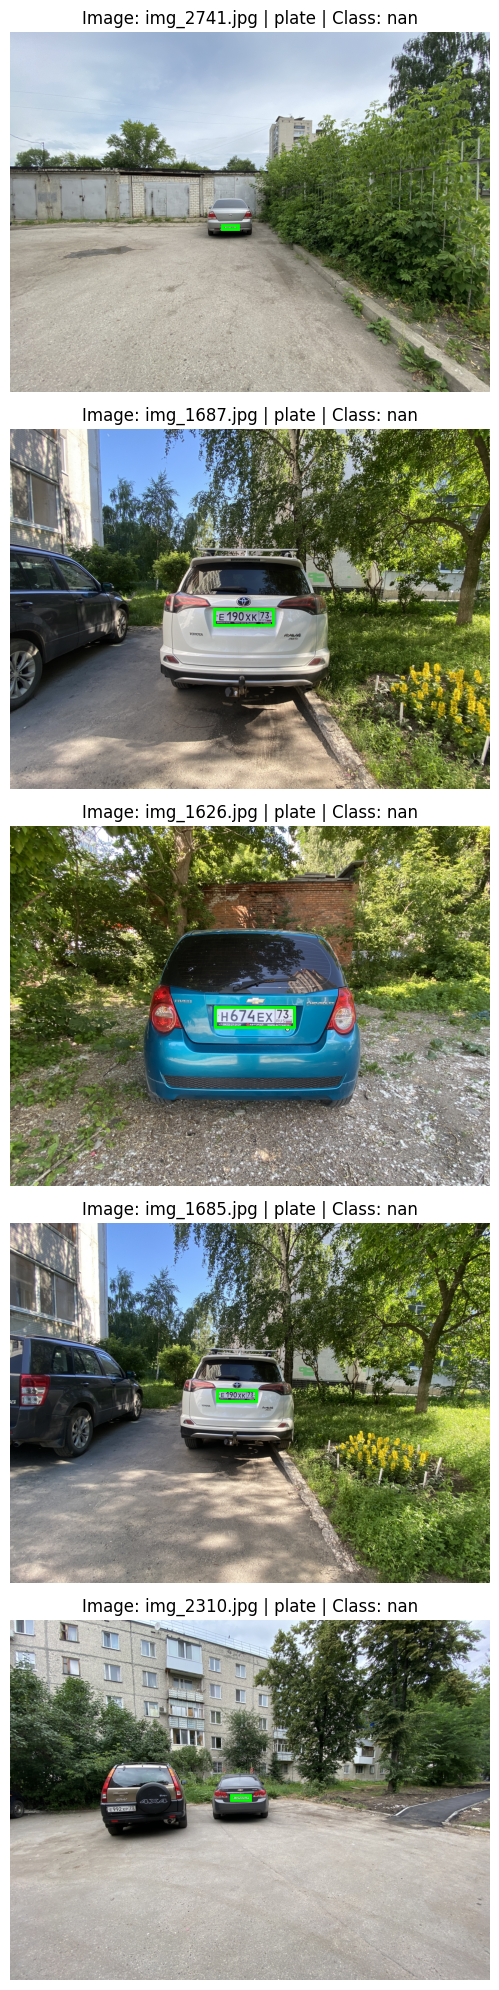

In [ ]:
class LicensePlateDataset:
    def __init__(self, annotations_df, data_dir):
        self.df = annotations_df
        self.data_dir = data_dir
        
        # If needed, create full paths to images
        if 'file' in self.df.columns:
            # For our dataset, images are in the same folder with .jpeg extension
            self.df['image_path'] = self.df['file'].apply(
                lambda f: os.path.join(data_dir, f + ".jpeg"))
        
        print(f"Dataset initialized with {len(self.df)} annotations")
    
    def get_sample_indices(self, n=5):
        """Get n random sample indices"""
        if 'file' in self.df.columns:
            # Get unique files first, then sample
            unique_files = self.df['file'].unique()
            sampled_files = random.sample(list(unique_files), min(n, len(unique_files)))
            # Get the first annotation for each sampled file
            indices = [self.df[self.df['file'] == f].index[0] for f in sampled_files]
            return indices
        else:
            # Just sample random indices
            return random.sample(range(len(self.df)), min(n, len(self.df)))
    
    def get_image_and_bbox(self, idx):
        """Get image and bounding box for a given index"""
        row = self.df.iloc[idx]
        
        # Get image path
        img_path = row['image_path']
        
        # Read the image
        try:
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not read image at {img_path}")
                return None, None, None
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f"Error reading image {img_path}: {e}")
            return None, None, None
        
        # Get bounding box coordinates from XML format
        # The DataFrame now has xmin, ymin, xmax, ymax directly from XML parsing
        if all(col in self.df.columns for col in ['xmin', 'ymin', 'xmax', 'ymax']):
            bbox = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
        else:
            print(f"Warning: Could not determine bbox format for row {idx}")
            bbox = None
        
        # Get class name
        class_name = row.get('class', 'plate') if 'class' in self.df.columns else 'plate'
        
        return img, bbox, class_name

    def visualize_samples(self, n=5):
        """Visualize n random samples from the dataset"""
        indices = self.get_sample_indices(n)
        
        plt.figure(figsize=(15, 4*n))
        
        for i, idx in enumerate(indices):
            img, bbox, class_name = self.get_image_and_bbox(idx)
            if img is None or bbox is None:
                continue
            
            plt.subplot(n, 1, i+1)
            
            # Extract bbox coordinates - now always in [xmin, ymin, xmax, ymax] format
            xmin, ymin, xmax, ymax = bbox
            width = xmax - xmin
            height = ymax - ymin
                    
            # Draw the bounding box
            plt.imshow(img)
            rect = plt.Rectangle((xmin, ymin), width, height, 
                                 fill=False, edgecolor='lime', linewidth=2)
            plt.gca().add_patch(rect)
            
            # Display image info
            row = self.df.iloc[idx]
            title = f"Image: {os.path.basename(row['image_path'])}"            
            title += f" | Class: {class_name}"
            plt.title(title)
            plt.axis('off')
            
        plt.tight_layout()
        plt.show()

# Set the data directory (contains both images and XML files)
data_dir = path

# Initialize the dataset if annotations are available
if annotations_df is not None:
    dataset = LicensePlateDataset(annotations_df, data_dir)
    
    # Visualize random samples
    dataset.visualize_samples(5)
else:
    print("Cannot initialize dataset without annotations")

## 5. Alternative Approach: Direct File System Scanning

If the annotations CSV isn't structured as expected, let's also implement a direct approach by scanning for image-CSV pairs directly.

In [ ]:
def scan_for_image_annotation_pairs(data_dir):
    """Scan the directory for image and annotation pairs"""
    print("Alternative approach: Direct scan for images and annotations")
    print(f"Checking data directory: {data_dir}")
    
    # Find image files
    image_files = []
    for file in os.listdir(data_dir):
        if file.lower().endswith('.jpeg'):
            image_files.append(os.path.join(data_dir, file))
    
    print(f"Found {len(image_files)} image files")
    
    # Find XML annotation files
    xml_files = []
    for file in os.listdir(data_dir):
        if file.lower().endswith('.xml'):
            xml_files.append(os.path.join(data_dir, file))
    
    print(f"Found {len(xml_files)} XML annotation files")
    
    # Match images with annotations
    image_bases = [os.path.splitext(os.path.basename(f))[0] for f in image_files]
    xml_bases = [os.path.splitext(os.path.basename(f))[0] for f in xml_files]
    
    matches = set(image_bases).intersection(set(xml_bases))
    print(f"Found {len(matches)} matching image-annotation pairs")
    
    return image_files, xml_files, matches

# Try the direct scanning approach
print("\nTrying alternative approach...")
if os.path.exists(data_dir):
    image_files, xml_files, matches = scan_for_image_annotation_pairs(data_dir)
else:
    print("Cannot perform direct scan - directory missing")

## 6. Simple Visualization with XML Data

Let's create a simple visualization that directly uses the XML annotation format.


Direct visualization from the CSV:


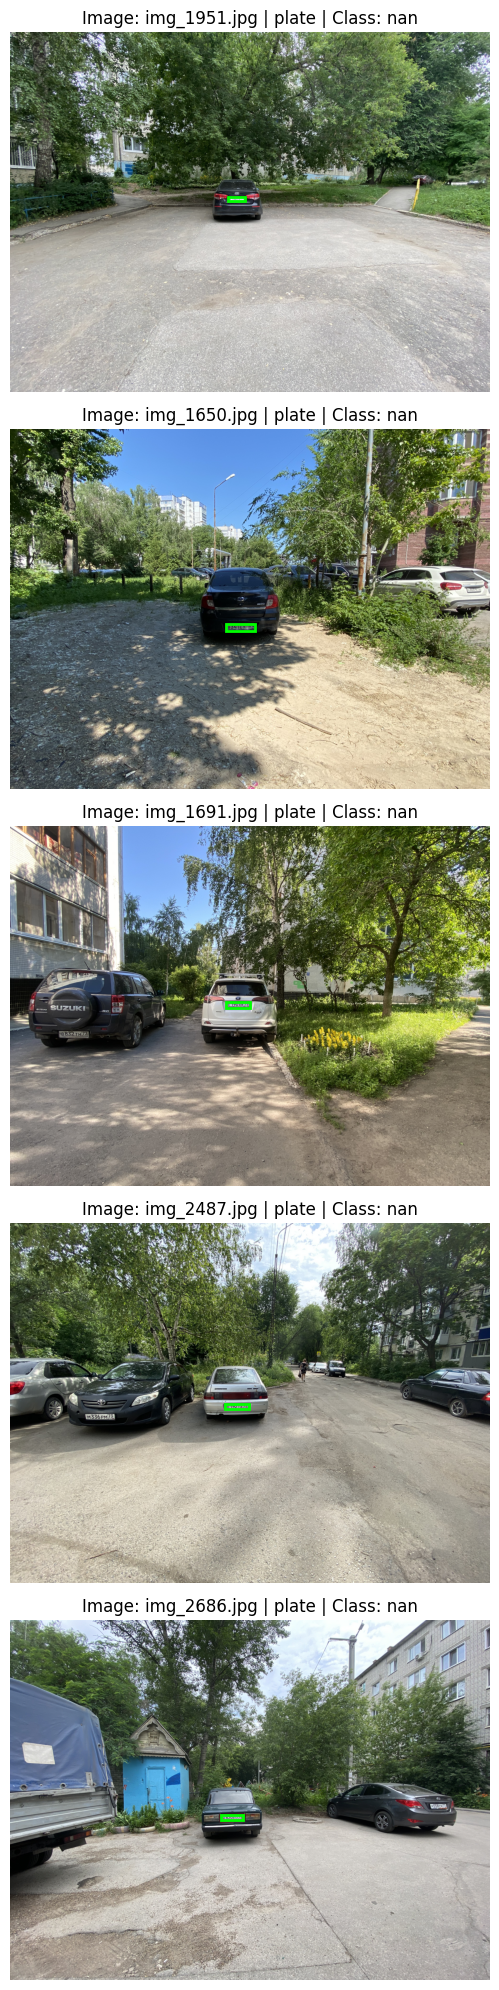

In [ ]:
def direct_visualization_from_xml(annotations_df, data_dir, n=5):
    """Visualize samples directly using the XML-based annotation DataFrame"""
    if annotations_df is None or len(annotations_df) == 0:
        print("No annotations available for visualization")
        return
    
    # Get a random sample of rows, prioritizing unique image files
    if 'file' in annotations_df.columns:
        # Sample unique image files
        unique_files = annotations_df['file'].unique()
        sampled_files = random.sample(list(unique_files), min(n, len(unique_files)))
        sampled_indices = [annotations_df[annotations_df['file'] == f].index[0] for f in sampled_files]
        sampled_rows = [annotations_df.iloc[i] for i in sampled_indices]
    else:
        # Just sample random rows
        sampled_indices = random.sample(range(len(annotations_df)), min(n, len(annotations_df)))
        sampled_rows = [annotations_df.iloc[i] for i in sampled_indices]
    
    plt.figure(figsize=(15, 4*n))
    
    for i, row in enumerate(sampled_rows):
        try:
            # Get image path - both XML and image files are in the same directory
            img_path = os.path.join(data_dir, row['file'] + ".jpeg")
                
            # Load image
            img = cv2.imread(img_path)
            if img is None:
                print(f"Error: Cannot read {img_path}")
                continue
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Extract bbox coordinates - XML format gives us xmin, ymin, xmax, ymax directly
            xmin = int(row['xmin'])
            ymin = int(row['ymin'])
            xmax = int(row['xmax'])
            ymax = int(row['ymax'])
            width = xmax - xmin
            height = ymax - ymin
            
            # Plot image with bounding box
            plt.subplot(n, 1, i+1)
            plt.imshow(img)
            rect = plt.Rectangle((xmin, ymin), width, height, 
                               fill=False, edgecolor='lime', linewidth=2)
            plt.gca().add_patch(rect)
            
            # Show image details
            title = f"Image: {os.path.basename(img_path)}"
            if 'class' in row:
                title += f" | Class: {row['class']}"
            plt.title(title)
            plt.axis('off')
            
        except Exception as e:
            print(f"Error visualizing row {i}: {e}")
            
    plt.tight_layout()
    plt.show()

# Try direct visualization from the XML annotations
if annotations_df is not None:
    print("\nDirect visualization from XML-based annotations:")
    direct_visualization_from_xml(annotations_df, data_dir)

## 7. Convert Annotations for Future Use

Let's create functions to convert these annotations to formats compatible with our custom CNN and YOLOv8 models.

In [ ]:
def convert_to_custom_cnn_format(annotations_df, output_dir, data_dir, image_size=(640, 640)):
    """
    Convert annotations to our custom CNN format:
    - Images resized to image_size
    - Bounding boxes normalized to [0,1] range in format (x, y, w, h)
    """
    if annotations_df is None:
        print("No annotations available for conversion")
        return
        
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize lists for processed data
    processed_images = []
    processed_bboxes = []
    
    # Process each unique image
    unique_files = annotations_df['file'].unique() if 'file' in annotations_df.columns else []
    
    for file in tqdm(unique_files, desc="Converting to CNN format"):
        try:
            # Get the row for this file
            row = annotations_df[annotations_df['file'] == file].iloc[0]
            
            # Load image - images and XML files are in the same directory
            img_path = os.path.join(data_dir, file + ".jpeg")
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not read image at {img_path}")
                continue
                
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            orig_height, orig_width = img_rgb.shape[:2]
            
            # Resize image
            img_resized = cv2.resize(img_rgb, image_size, interpolation=cv2.INTER_AREA)
            
            # Normalize pixel values
            img_normalized = img_resized.astype("float32") / 255.0
            
            # Extract bbox coordinates
            # XML format already provides xmin, ymin, xmax, ymax directly
            xmin = row['xmin']
            ymin = row['ymin']
            xmax = row['xmax']
            ymax = row['ymax']
            width = xmax - xmin
            height = ymax - ymin
            
            # Rescale coordinates to normalized [0,1] range
            x_scale = image_size[0] / orig_width
            y_scale = image_size[1] / orig_height
            
            # Calculate center point and normalized dimensions
            # YOLO format uses center_x, center_y, width, height - all normalized
            center_x = (xmin + width/2) * x_scale / image_size[0]
            center_y = (ymin + height/2) * y_scale / image_size[1]
            norm_width = width * x_scale / image_size[0]
            norm_height = height * y_scale / image_size[1]
            
            bbox_normalized = [center_x, center_y, norm_width, norm_height]
            
            # Save the processed data
            processed_images.append(img_normalized)
            processed_bboxes.append(bbox_normalized)
            
        except Exception as e:
            print(f"Error processing {file}: {e}")
    
    # Convert to NumPy arrays
    if processed_images:
        X = np.array(processed_images)
        y = np.array(processed_bboxes)
        
        # Save the processed data
        np.save(os.path.join(output_dir, 'processed_images.npy'), X)
        np.save(os.path.join(output_dir, 'processed_bboxes.npy'), y)
        
        print(f"Saved processed data to {output_dir}")
        print(f"Processed {len(X)} images")
        print(f"Image shape: {X[0].shape}")
        print(f"Sample bounding box: {y[0]}")
    else:
        print("No images were processed successfully")

# Create a function to convert to YOLO format
def convert_to_yolo_format(annotations_df, output_dir, data_dir):
    """
    Convert XML annotations to YOLO format:
    - One .txt file per image
    - Each line: <class_id> <center_x> <center_y> <width> <height>
    - All values normalized to [0,1]
    """
    if annotations_df is None:
        print("No annotations available for conversion")
        return
        
    # Create output directories
    labels_dir = os.path.join(output_dir, 'labels')
    os.makedirs(labels_dir, exist_ok=True)
    
    # Create a class mapping
    classes = annotations_df['class'].unique()
    class_to_id = {name: i for i, name in enumerate(classes)}
    
    print(f"Class mapping: {class_to_id}")
    
    # Process each unique image
    unique_files = annotations_df['file'].unique()
    
    for file in tqdm(unique_files, desc="Converting to YOLO format"):
        try:
            # Get all annotations for this image
            image_annotations = annotations_df[annotations_df['file'] == file]
            
            # Get image dimensions
            img_path = os.path.join(data_dir, file + ".jpeg")
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not read image at {img_path}")
                continue
                
            img_height, img_width = img.shape[:2]
            
            # Create YOLO format annotations
            yolo_lines = []
            for _, row in image_annotations.iterrows():
                # Get class ID
                class_name = row['class']
                class_id = class_to_id[class_name]
                
                # Convert bbox to YOLO format
                xmin = row['xmin']
                ymin = row['ymin']
                xmax = row['xmax']
                ymax = row['ymax']
                
                # Calculate center point and dimensions
                center_x = (xmin + (xmax - xmin) / 2) / img_width
                center_y = (ymin + (ymax - ymin) / 2) / img_height
                width = (xmax - xmin) / img_width
                height = (ymax - ymin) / img_height
                
                # Add line to YOLO file
                yolo_lines.append(f"{class_id} {center_x:.6f} {center_y:.6f} {width:.6f} {height:.6f}")
            
            # Write YOLO format file
            yolo_file = os.path.join(labels_dir, file + ".txt")
            with open(yolo_file, 'w') as f:
                f.write('\n'.join(yolo_lines))
                
        except Exception as e:
            print(f"Error processing {file}: {e}")
    
    # Save class mapping
    classes_file = os.path.join(output_dir, 'classes.txt')
    with open(classes_file, 'w') as f:
        for name, _ in sorted(class_to_id.items(), key=lambda x: x[1]):
            f.write(f"{name}\n")
    
    print(f"\nYOLO conversion completed:")
    print(f"- Labels saved to: {labels_dir}")
    print(f"- Classes saved to: {classes_file}")

# If you want to convert annotations for future use, uncomment these lines
# if annotations_df is not None and data_dir:
#     # Convert to custom CNN format
#     cnn_output_dir = os.path.join(base_dir, 'cnn_formatted')
#     convert_to_custom_cnn_format(annotations_df, cnn_output_dir, data_dir)
#     
#     # Convert to YOLO format
#     yolo_output_dir = os.path.join(base_dir, 'yolo_formatted')
#     convert_to_yolo_format(annotations_df, yolo_output_dir, data_dir)

## Summary

In this notebook, we:

1. Loaded the license plate detection dataset from the local DataV3 folder
2. Explored the dataset structure to understand the organization of XML annotation files
3. Implemented a parser for XML annotation files
4. Created visualization functions to display images with bounding boxes
5. Added support for converting the XML annotations to different formats (custom CNN and YOLO)

The visualizations confirm that we can successfully load the data and the annotations are correctly displaying the license plates in the images. This dataset can now be used for further model training and evaluation.

## Next Steps

With this dataset loaded, you can:

1. Use the data for training a custom CNN model with the improvements mentioned earlier:
   - Data augmentation
   - Pretrained backbone
   - Anchor-based detection
   - Feature Pyramid Network
   
2. Convert the dataset to YOLO format for training a YOLOv8 model

3. Compare the performance of both approaches

## 8. Helper Function for Single XML Visualization

This function allows you to visualize a single XML annotation file and its corresponding image.

In [ ]:
# Function to visualize a single XML annotation file
def visualize_single_xml(xml_file, data_dir):
    """Visualize a single XML annotation file"""
    # Parse the XML file
    annotation = parse_xml_annotation(xml_file)
    if not annotation:
        print(f"Could not parse {xml_file}")
        return
    
    # Load image - both image and XML are in same directory
    xml_basename = os.path.splitext(os.path.basename(xml_file))[0]
    img_path = os.path.join(data_dir, xml_basename + ".jpeg")
    
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not read image for {xml_file} at {img_path}")
        return
        
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display image with bounding boxes
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    
    # Draw each object
    for obj in annotation['objects']:
        xmin = obj['xmin']
        ymin = obj['ymin']
        xmax = obj['xmax']
        ymax = obj['ymax']
        width = xmax - xmin
        height = ymax - ymin
        
        # Create rectangle
        rect = plt.Rectangle((xmin, ymin), width, height,
                            fill=False, edgecolor='lime', linewidth=2)
        plt.gca().add_patch(rect)
        
        # Add label
        plt.text(xmin, ymin-10, obj['name'],
                fontsize=12, color='white', backgroundcolor='green')
    
    # Set title
    plt.title(f"Image: {os.path.basename(img_path)}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# To use this function, uncomment the following lines and provide an XML file path
# if xml_files and len(xml_files) > 0:
#     sample_xml = xml_files[0]
#     visualize_single_xml(sample_xml, data_dir)